In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

Double check by plotting

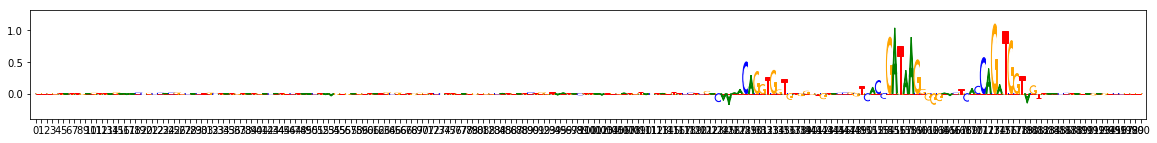

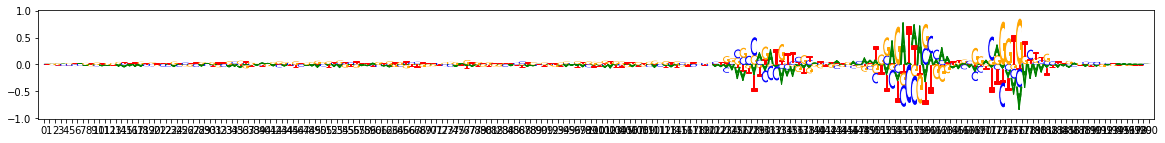

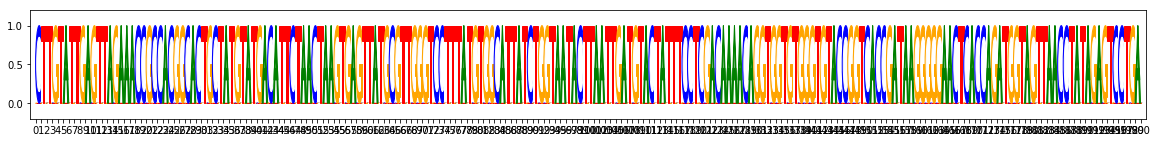

In [10]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

Using laplace threshold of 0.996639784946
On task task0
Computing windowed sums
Computing threshold


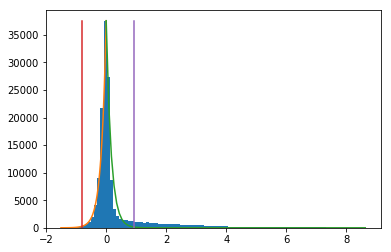

Computed thresholds -0.820521075502268 and 0.9214706538412227
Got 1443 coords
On task task1
Computing windowed sums
Computing threshold


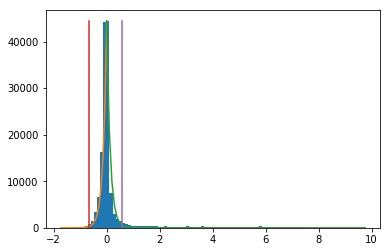

Computed thresholds -0.6598852652768249 and 0.5718214843327963
Got 1204 coords
On task task2
Computing windowed sums
Computing threshold


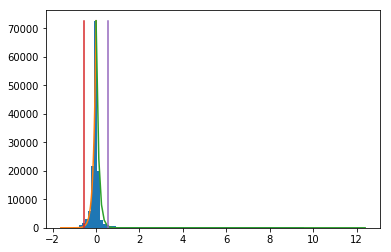

Computed thresholds -0.5698989198136961 and 0.5431801403347247
Got 1314 coords
After resolving overlaps, got 2190 seqlets
7 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [682, 636, 252, 188, 167, 162, 103]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1', 4: '1,1,1', 5: '0,0,-1', 6: '0,-1,0'}
On metacluster 6
Metacluster size 103
Relevant tasks:  ('task1',)
Relevant signs:  (-1,)
(Round 1) num seqlets: 103
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.14 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbor

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished
WARNING!!! only 199 louvain runs worked, out of 200


Louvain completed 200 runs in 1.13387799263 seconds
Wrote graph to binary file in 0.00545620918274 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.739444
After 5 runs, maximum modularity is Q = 0.748937
Louvain completed 55 runs in 0.74546790123 seconds
Preproc + Louvain took 1.91893315315 s
Got 7 clusters after round 1
Counts:
{0: 21, 1: 17, 2: 14, 3: 9, 4: 8, 5: 8, 6: 4}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 21 seqlets
Trimmed 0 out of 21
Aggregating for cluster 1 with 17 seqlets
Trimmed 0 out of 17
Skipped 1 seqlets
Dropping cluster 1 with 16 seqlets due to sign disagreement
Aggregating for cluster 2 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 3 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 4 with 8 seqlets
Trimmed 0 out of 8
Aggregating for cluster 5 with 8 seqlets
Trimmed 0 out of 8
Skipped 1 seqlets
Aggregating for cluster 6 with 4 seqlets
Trimmed 0 out of 4
(Round 2) num 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.7s finished


Louvain completed 200 runs in 1.10922503471 seconds
Wrote graph to binary file in 0.00357699394226 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.835494
Louvain completed 51 runs in 0.63839507103 seconds
Preproc + Louvain took 1.78298187256 s
Got 7 clusters after round 2
Counts:
{0: 11, 1: 10, 2: 10, 3: 10, 4: 9, 5: 8, 6: 5}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 11 seqlets
Trimmed 0 out of 11
Aggregating for cluster 1 with 10 seqlets
Trimmed 3 out of 10
Aggregating for cluster 2 with 10 seqlets
Trimmed 2 out of 10
Aggregating for cluster 3 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 4 with 9 seqlets
Trimmed 2 out of 9
Aggregating for cluster 5 with 8 seqlets
Trimmed 0 out of 8
Aggregating for cluster 6 with 5 seqlets
Trimmed 0 out of 5
Got 7 clusters
Splitting into subclusters...
Merging on 7 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished
WARNING!!! only 199 louvain runs worked, out of 200


Louvain completed 200 runs in 1.12931013107 seconds
Wrote graph to binary file in 0.0168190002441 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.776763
Louvain completed 51 runs in 0.689650058746 seconds
Preproc + Louvain took 1.87711501122 s
Got 8 clusters after round 1
Counts:
{0: 26, 1: 19, 2: 16, 3: 16, 4: 14, 5: 14, 6: 12, 7: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 26 seqlets
Trimmed 10 out of 26
Dropping cluster 0 with 16 seqlets due to sign disagreement
Aggregating for cluster 1 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 2 with 16 seqlets
Trimmed 0 out of 16
Skipped 1 seqlets
Aggregating for cluster 3 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 4 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 5 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 6 with 12 seqlets
Trimmed 0 out of 12
Skipped 1 seqlets
Aggregating for cluster 7 with 11 seqlets
T

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.14771604538 seconds
Wrote graph to binary file in 0.00607180595398 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.769687
Louvain completed 51 runs in 0.673405885696 seconds
Preproc + Louvain took 1.86108088493 s
Got 9 clusters after round 2
Counts:
{0: 12, 1: 12, 2: 12, 3: 12, 4: 11, 5: 10, 6: 9, 7: 9, 8: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 1 with 12 seqlets
Trimmed 1 out of 12
Aggregating for cluster 2 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 3 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 4 with 11 seqlets
Trimmed 2 out of 11
Aggregating for cluster 5 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 6 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 7 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 8 with 2 seqlets
Trimmed 0 out of 2
Got 9 clusters
Sp

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished
WARNING!!! only 199 louvain runs worked, out of 200


Louvain completed 200 runs in 1.25020098686 seconds
Wrote graph to binary file in 0.02073097229 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.669825
Louvain completed 51 runs in 0.682971954346 seconds
Preproc + Louvain took 1.99104404449 s
Got 6 clusters after round 1
Counts:
{0: 45, 1: 39, 2: 29, 3: 27, 4: 17, 5: 3}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 45 seqlets
Trimmed 2 out of 45
Skipped 1 seqlets
Aggregating for cluster 1 with 39 seqlets
Trimmed 0 out of 39
Skipped 5 seqlets
Aggregating for cluster 2 with 29 seqlets
Trimmed 0 out of 29
Skipped 1 seqlets
Aggregating for cluster 3 with 27 seqlets
Trimmed 1 out of 27
Skipped 1 seqlets
Aggregating for cluster 4 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 5 with 3 seqlets
Trimmed 0 out of 3
(Round 2) num seqlets: 149
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.25437808037 seconds
Wrote graph to binary file in 0.0172128677368 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.60223
Louvain completed 51 runs in 0.653950929642 seconds
Preproc + Louvain took 1.96746516228 s
Got 6 clusters after round 2
Counts:
{0: 53, 1: 43, 2: 18, 3: 12, 4: 12, 5: 11}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 53 seqlets
Trimmed 0 out of 53
Aggregating for cluster 1 with 43 seqlets
Trimmed 1 out of 43
Aggregating for cluster 2 with 18 seqlets
Trimmed 1 out of 18
Aggregating for cluster 3 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 4 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 5 with 11 seqlets
Trimmed 0 out of 11
Got 6 clusters
Splitting into subclusters...
Merging on 6 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 2 with prob 6.0034806554077556e-05 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.28982281685 seconds
Wrote graph to binary file in 0.0212290287018 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.584575
After 5 runs, maximum modularity is Q = 0.592173
After 11 runs, maximum modularity is Q = 0.595253
After 54 runs, maximum modularity is Q = 0.609594
Louvain completed 104 runs in 1.36705803871 seconds
Preproc + Louvain took 2.71769690514 s
Got 7 clusters after round 1
Counts:
{0: 58, 1: 36, 2: 19, 3: 18, 4: 16, 5: 10, 6: 9}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 58 seqlets
Trimmed 6 out of 58
Skipped 5 seqlets
Aggregating for cluster 1 with 36 seqlets
Trimmed 10 out of 36
Skipped 1 seqlets
Aggregating for cluster 2 with 19 seqlets
Trimmed 2 out of 19
Aggregating for cluster 3 with 18 seqlets
Trimmed 0 out of 18
Skipped 2 seqlets
Aggregating for cluster 4 with 16 seqlets
Trimmed 1 out of 16
Aggregating for cluster 5 with 10 seqlets
Trimmed 1 out of 10
Aggreg

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.36744403839 seconds
Wrote graph to binary file in 0.0186321735382 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.724549
Louvain completed 51 runs in 0.662562131882 seconds
Preproc + Louvain took 2.09880900383 s
Got 7 clusters after round 2
Counts:
{0: 30, 1: 30, 2: 26, 3: 18, 4: 15, 5: 13, 6: 6}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 30 seqlets
Trimmed 3 out of 30
Aggregating for cluster 1 with 30 seqlets
Trimmed 3 out of 30
Skipped 1 seqlets
Aggregating for cluster 2 with 26 seqlets
Trimmed 1 out of 26
Aggregating for cluster 3 with 18 seqlets
Trimmed 0 out of 18
Skipped 1 seqlets
Aggregating for cluster 4 with 15 seqlets
Trimmed 2 out of 15
Aggregating for cluster 5 with 13 seqlets
Trimmed 3 out of 13
Aggregating for cluster 6 with 6 seqlets
Trimmed 0 out of 6
Got 7 clusters
Splitting into subclusters...
Merging on 7 clusters
On merging iteration 1
Computing pattern to seq

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.39404201508 seconds
Wrote graph to binary file in 0.0166611671448 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.638288
Louvain completed 51 runs in 0.698205947876 seconds
Preproc + Louvain took 2.14725995064 s
Got 5 clusters after round 1
Counts:
{0: 54, 1: 37, 2: 34, 3: 29, 4: 22}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 54 seqlets
Trimmed 6 out of 54
Skipped 1 seqlets
Aggregating for cluster 1 with 37 seqlets
Trimmed 1 out of 37
Aggregating for cluster 2 with 34 seqlets
Trimmed 12 out of 34
Aggregating for cluster 3 with 29 seqlets
Trimmed 0 out of 29
Skipped 1 seqlets
Skipped 1 seqlets
Aggregating for cluster 4 with 22 seqlets
Trimmed 4 out of 22
(Round 2) num seqlets: 150
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.2 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.27914810181 seconds
Wrote graph to binary file in 0.0136280059814 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.716024
Louvain completed 51 runs in 0.683218955994 seconds
Preproc + Louvain took 2.0151488781 s
Got 10 clusters after round 2
Counts:
{0: 23, 1: 22, 2: 21, 3: 17, 4: 16, 5: 16, 6: 15, 7: 14, 8: 4, 9: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 1 with 22 seqlets
Trimmed 0 out of 22
Aggregating for cluster 2 with 21 seqlets
Trimmed 2 out of 21
Skipped 1 seqlets
Aggregating for cluster 3 with 17 seqlets
Trimmed 0 out of 17
Skipped 1 seqlets
Aggregating for cluster 4 with 16 seqlets
Trimmed 1 out of 16
Skipped 1 seqlets
Aggregating for cluster 5 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 6 with 15 seqlets
Trimmed 0 out of 15
Skipped 1 seqlets
Aggregating for cluster 7 with 14 seqlets
Trimmed 0 out 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.4s finished


Louvain completed 200 runs in 2.01576209068 seconds
Wrote graph to binary file in 0.161088943481 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.681839
After 27 runs, maximum modularity is Q = 0.681903
Louvain completed 77 runs in 1.55799794197 seconds
Preproc + Louvain took 3.82811903954 s
Got 8 clusters after round 1
Counts:
{0: 114, 1: 100, 2: 87, 3: 72, 4: 65, 5: 42, 6: 37, 7: 37}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 114 seqlets
Trimmed 17 out of 114
Skipped 8 seqlets
Aggregating for cluster 1 with 100 seqlets
Trimmed 2 out of 100
Skipped 3 seqlets
Aggregating for cluster 2 with 87 seqlets
Trimmed 4 out of 87
Skipped 5 seqlets
Aggregating for cluster 3 with 72 seqlets
Trimmed 1 out of 72
Skipped 6 seqlets
Aggregating for cluster 4 with 65 seqlets
Trimmed 5 out of 65
Skipped 2 seqlets
Aggregating for cluster 5 with 42 seqlets
Trimmed 3 out of 42
Aggregating for cluster 6 with 37 seqlets
Trimmed 0 out o

[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.4s finished


Louvain completed 200 runs in 1.95270395279 seconds
Wrote graph to binary file in 0.120358943939 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.632252
After 3 runs, maximum modularity is Q = 0.650402
Louvain completed 53 runs in 0.996396064758 seconds
Preproc + Louvain took 3.16175913811 s
Got 9 clusters after round 2
Counts:
{0: 89, 1: 82, 2: 82, 3: 72, 4: 50, 5: 35, 6: 35, 7: 31, 8: 10}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 89 seqlets
Trimmed 16 out of 89
Aggregating for cluster 1 with 82 seqlets
Trimmed 1 out of 82
Aggregating for cluster 2 with 82 seqlets
Trimmed 1 out of 82
Aggregating for cluster 3 with 72 seqlets
Trimmed 5 out of 72
Aggregating for cluster 4 with 50 seqlets
Trimmed 1 out of 50
Aggregating for cluster 5 with 35 seqlets
Trimmed 0 out of 35
Aggregating for cluster 6 with 35 seqlets
Trimmed 5 out of 35
Aggregating for cluster 7 with 31 seqlets
Trimmed 0 out of 31
Aggregating for cluste

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.9s finished


Louvain completed 200 runs in 2.76529788971 seconds
Wrote graph to binary file in 0.243613958359 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.646614
After 2 runs, maximum modularity is Q = 0.650366
After 4 runs, maximum modularity is Q = 0.65045
After 11 runs, maximum modularity is Q = 0.65825
After 16 runs, maximum modularity is Q = 0.659227
After 54 runs, maximum modularity is Q = 0.659262
Louvain completed 104 runs in 2.8098320961 seconds
Preproc + Louvain took 5.97366213799 s
Got 8 clusters after round 1
Counts:
{0: 109, 1: 104, 2: 101, 3: 94, 4: 73, 5: 61, 6: 61, 7: 25}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 109 seqlets
Trimmed 4 out of 109
Skipped 6 seqlets
Aggregating for cluster 1 with 104 seqlets
Trimmed 4 out of 104
Skipped 6 seqlets
Aggregating for cluster 2 with 101 seqlets
Trimmed 12 out of 101
Skipped 5 seqlets
Aggregating for cluster 3 with 94 seqlets
Trimmed 3 out of 94
Skipped 8 seqlets


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.4s finished


Louvain completed 200 runs in 3.42824316025 seconds
Wrote graph to binary file in 0.214491128922 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.65485
After 2 runs, maximum modularity is Q = 0.672873
After 4 runs, maximum modularity is Q = 0.674885
Louvain completed 54 runs in 1.59171414375 seconds
Preproc + Louvain took 5.41236710548 s
Got 9 clusters after round 2
Counts:
{0: 122, 1: 92, 2: 69, 3: 59, 4: 53, 5: 43, 6: 40, 7: 37, 8: 23}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 122 seqlets
Trimmed 0 out of 122
Aggregating for cluster 1 with 92 seqlets
Trimmed 3 out of 92
Aggregating for cluster 2 with 69 seqlets
Trimmed 10 out of 69
Aggregating for cluster 3 with 59 seqlets
Trimmed 0 out of 59
Aggregating for cluster 4 with 53 seqlets
Trimmed 0 out of 53
Aggregating for cluster 5 with 43 seqlets
Trimmed 3 out of 43
Aggregating for cluster 6 with 40 seqlets
Trimmed 2 out of 40
Aggregating for cluster 7 with 37 

In [9]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [10]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

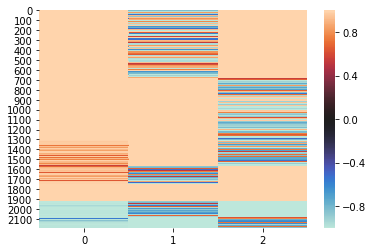

metacluster0
activity pattern: [1 0 1]
pattern_0
total seqlets: 511
Task 0 hypothetical scores:


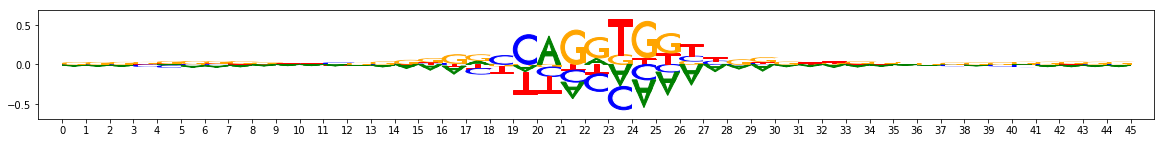

Task 0 actual importance scores:


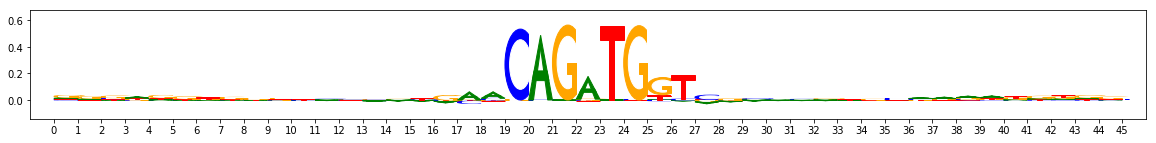

Task 1 hypothetical scores:


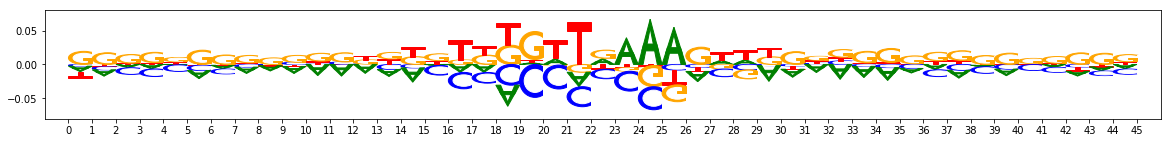

Task 1 actual importance scores:


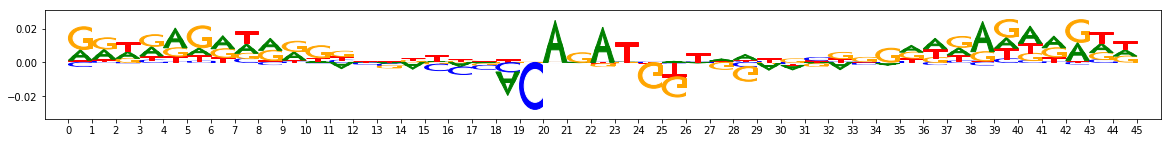

Task 2 hypothetical scores:


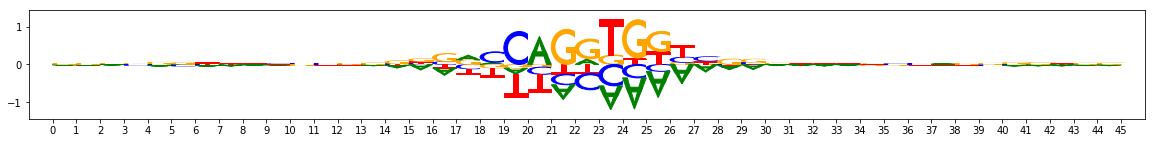

Task 2 actual importance scores:


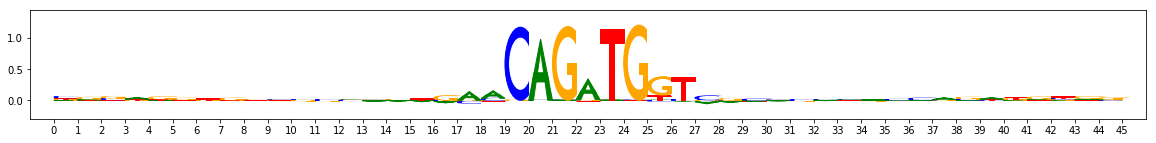

onehot, fwd and rev:


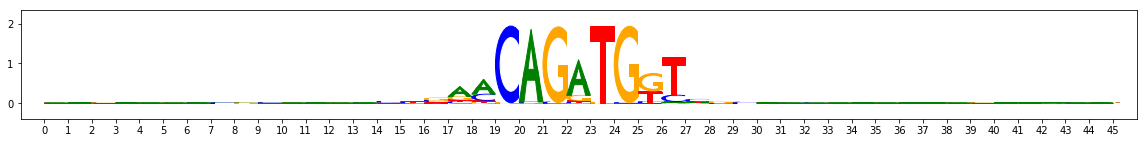

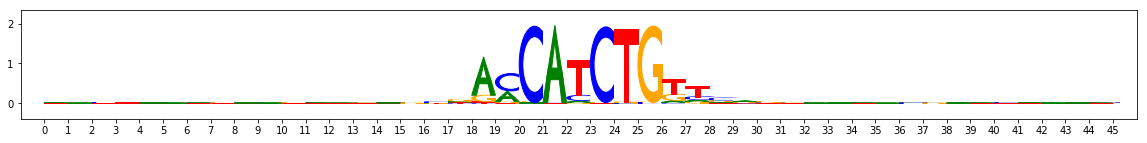

metacluster1
activity pattern: [1 1 0]
pattern_0
total seqlets: 442
Task 0 hypothetical scores:


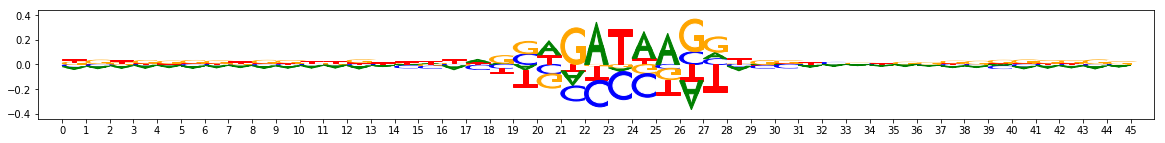

Task 0 actual importance scores:


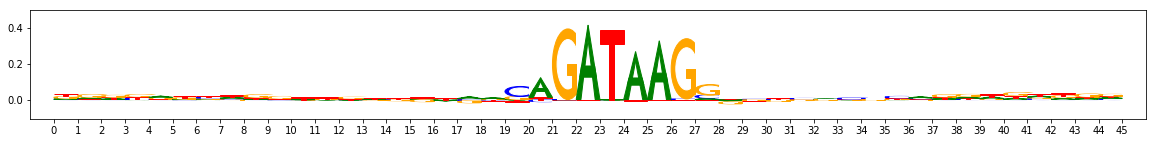

Task 1 hypothetical scores:


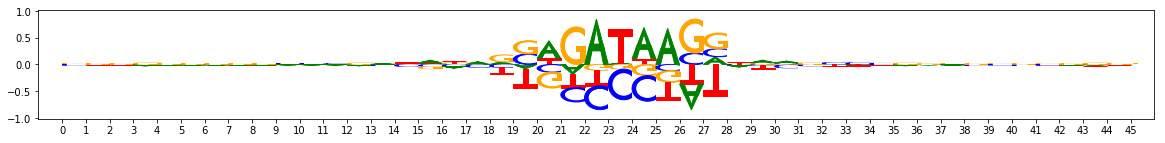

Task 1 actual importance scores:


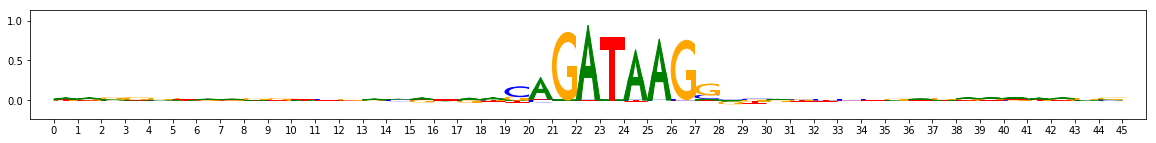

Task 2 hypothetical scores:


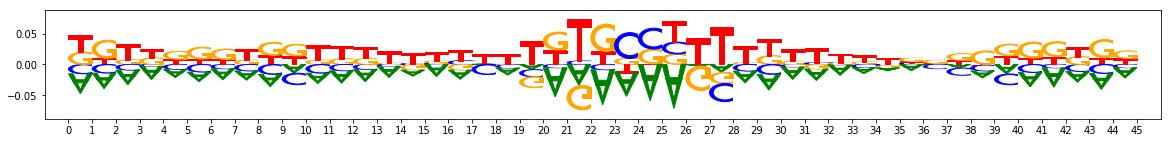

Task 2 actual importance scores:


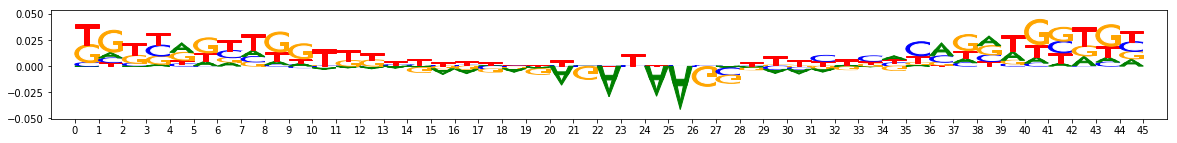

onehot, fwd and rev:


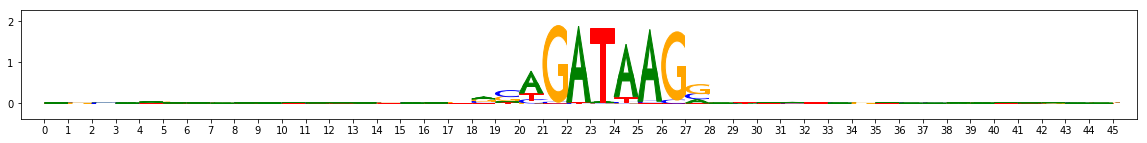

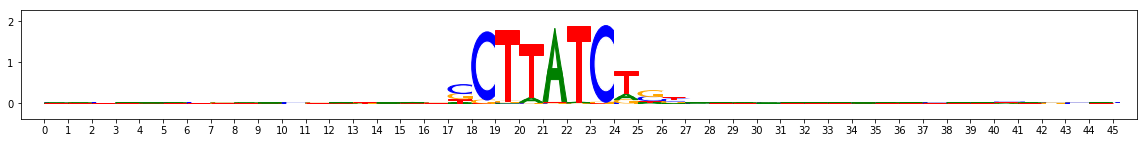

metacluster2
activity pattern: [0 1 0]
pattern_0
total seqlets: 131
Task 0 hypothetical scores:


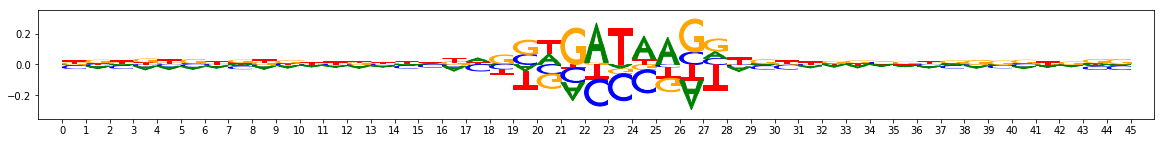

Task 0 actual importance scores:


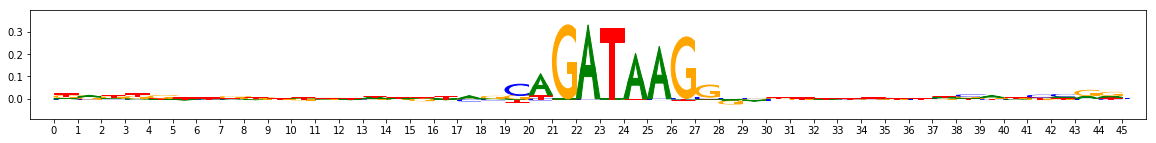

Task 1 hypothetical scores:


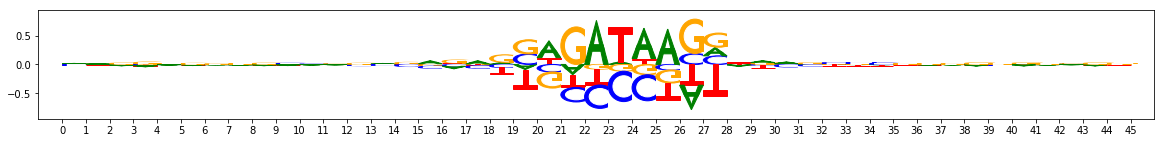

Task 1 actual importance scores:


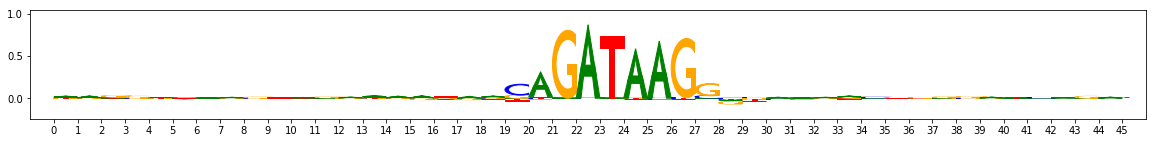

Task 2 hypothetical scores:


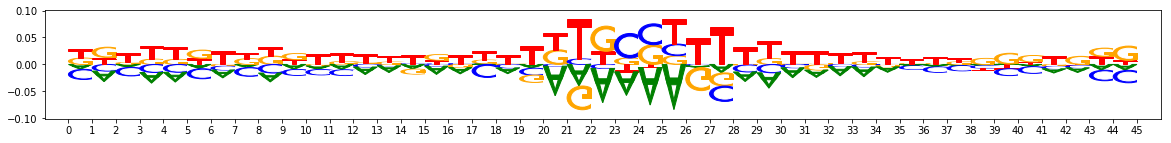

Task 2 actual importance scores:


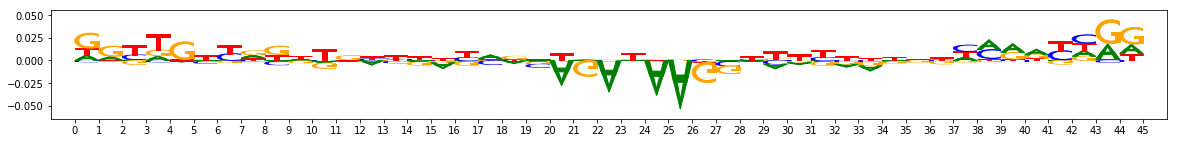

onehot, fwd and rev:


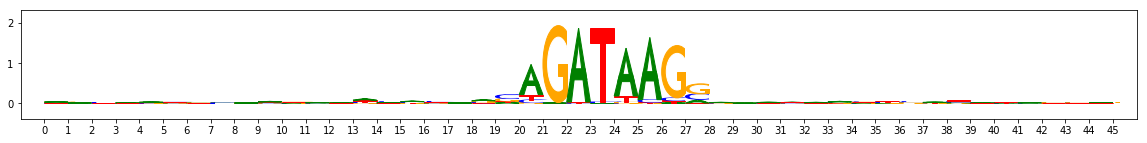

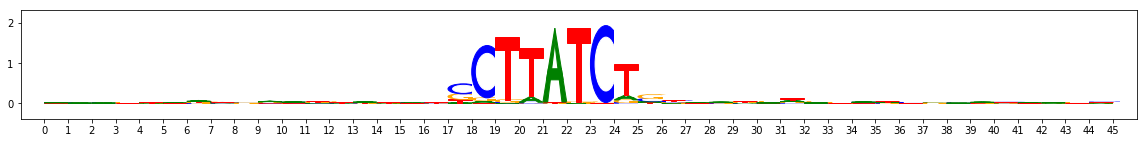

metacluster3
activity pattern: [0 0 1]
pattern_0
total seqlets: 105
Task 0 hypothetical scores:


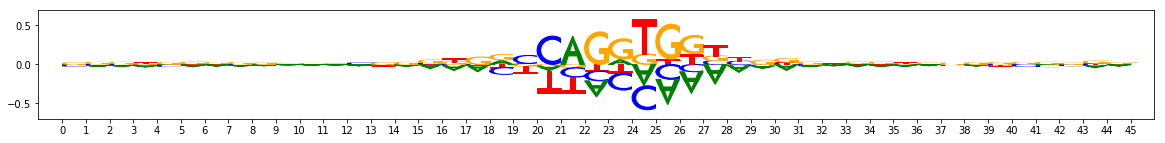

Task 0 actual importance scores:


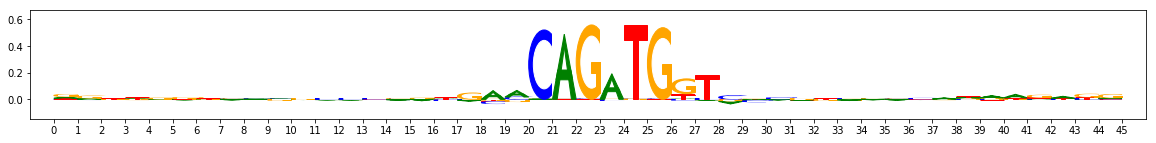

Task 1 hypothetical scores:


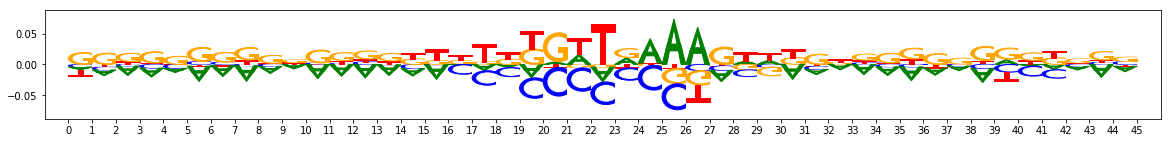

Task 1 actual importance scores:


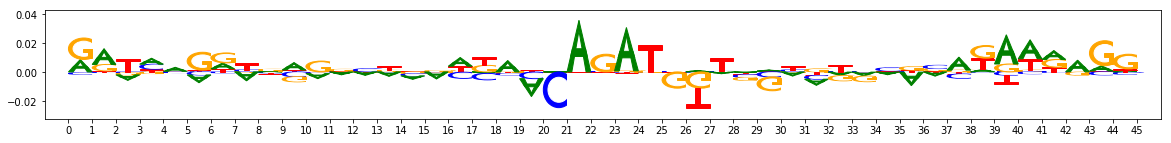

Task 2 hypothetical scores:


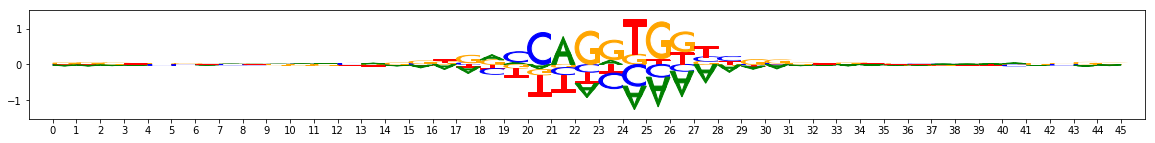

Task 2 actual importance scores:


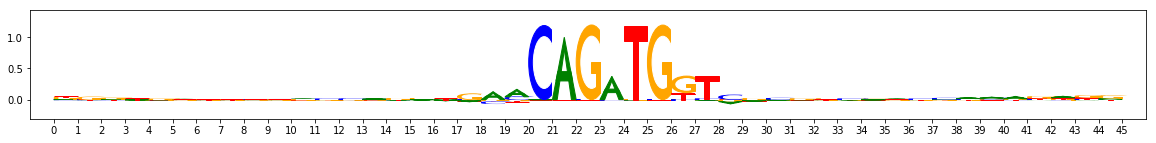

onehot, fwd and rev:


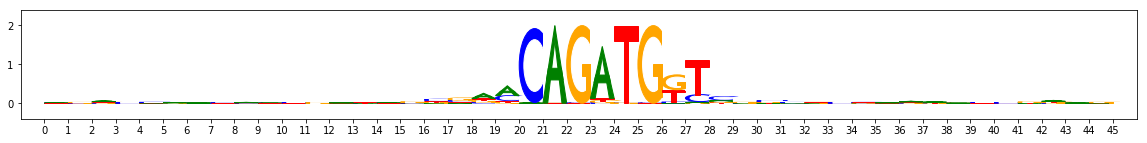

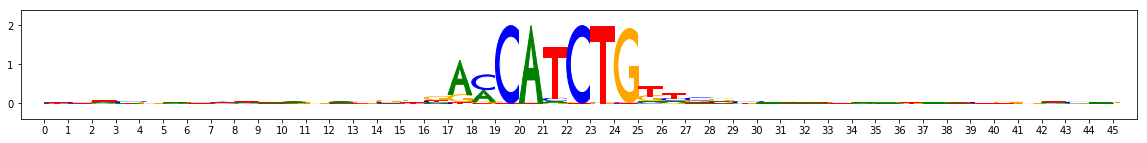

metacluster4
activity pattern: [1 1 1]
pattern_0
total seqlets: 106
Task 0 hypothetical scores:


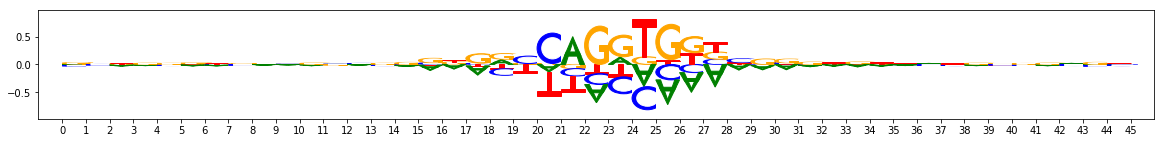

Task 0 actual importance scores:


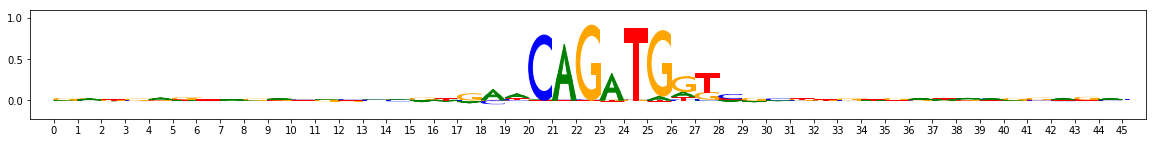

Task 1 hypothetical scores:


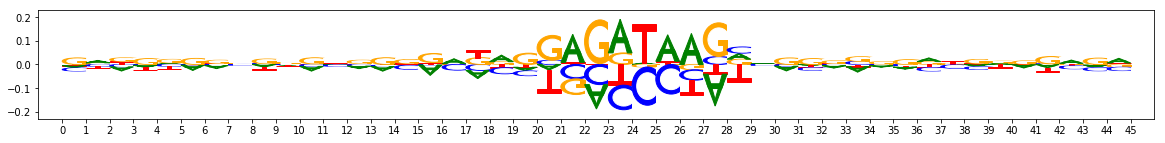

Task 1 actual importance scores:


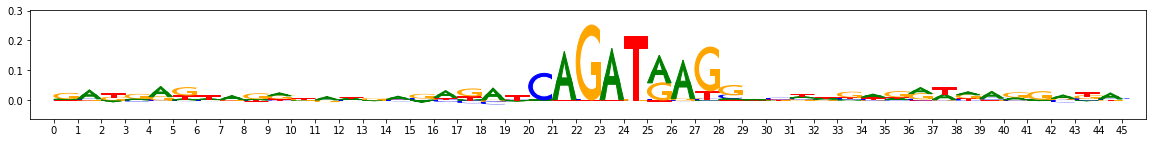

Task 2 hypothetical scores:


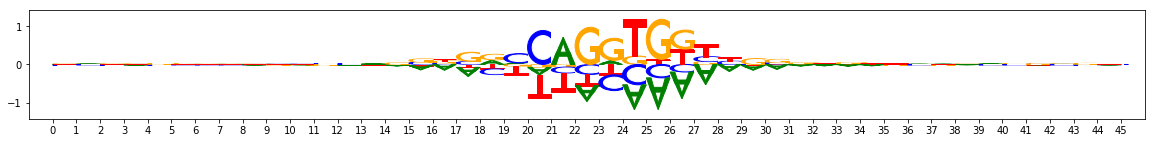

Task 2 actual importance scores:


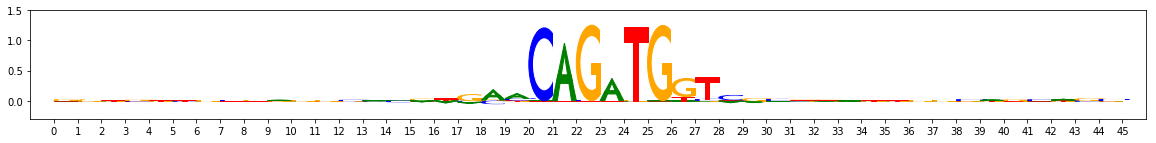

onehot, fwd and rev:


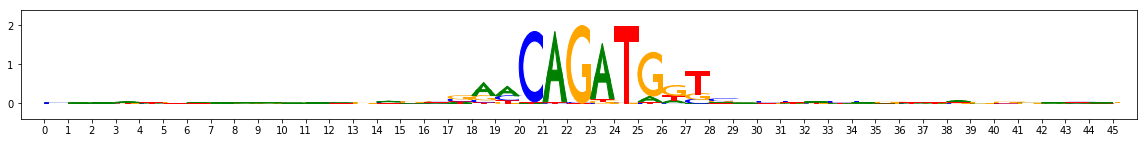

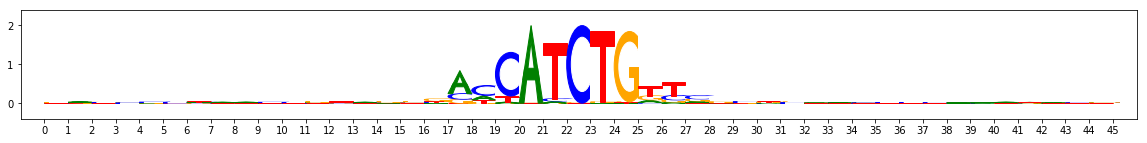

metacluster5
activity pattern: [ 0  0 -1]
No motifs found for this activity pattern
metacluster6
activity pattern: [ 0 -1  0]
No motifs found for this activity pattern


In [11]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()